In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

import spacy

In [2]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)

In [3]:
mails = pd.read_csv('merged_datasets.csv')
categories = pd.CategoricalDtype(['safe', 'phishing'], ordered=True)
mails['label'] = mails['label'].astype(categories)

In [4]:
mails.drop_duplicates(subset=['subject', 'sender_mail'], keep='first', inplace=True)
mails.dropna(subset=['body', 'sender_mail'], inplace=True)

In [5]:
def extract_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    matches = re.findall(url_pattern, text)

    return matches, len(matches)


mails[['extracted_urls', 'urls_count']] = mails['body'].apply(lambda x: pd.Series(extract_urls(x)))

def map_url_lens(lens):
    if lens <= 2:
        return str(lens)
    else:
        return '3<='


mails['urls_count'] = mails['urls_count'].apply(map_url_lens)
categories = pd.CategoricalDtype(['0', '1', '2', '3<='], ordered=True)
mails['urls_count'] = mails['urls_count'].astype(categories)

In [6]:
# Jeżeli jeden url w mailu jest fałszywy, to wychodzimy z założenia, że inne też
def return_random_url(urls):
    urls_len = len(urls)
    if urls_len == 0:
        return None

    random_index = np.random.randint(0, urls_len)
    randomized_url = urls[random_index]
    return randomized_url

mails['in_body_url'] = mails['extracted_urls'].apply(return_random_url)

# TUTAJ NASTĘPUJE CIĘCIE USELESS WIERSZY

In [7]:
print(mails.shape)
mails.dropna(subset=['in_body_url'], inplace=True)
print(mails.shape)
print(mails.label.value_counts(normalize=True))

(87633, 8)
(41716, 8)
label
phishing    0.614944
safe        0.385056
Name: proportion, dtype: float64


In [8]:
def is_https(url):
    protocol = url[:5].lower()
    return 'https' if protocol == 'https' else 'http'


mails['protocol'] = mails['in_body_url'].apply(is_https)
categories = pd.CategoricalDtype(['http', 'https'], ordered=True)
mails['protocol'] = mails['protocol'].astype(categories)

In [9]:
def contains_ip(url):
    ip_pattern = re.compile(r'\b(?:\d{1,3}\.){3}\d{1,3}\b|\b(?:[0-9a-fA-F]{1,4}:){7}[0-9a-fA-F]{1,4}\b')
    ips = ip_pattern.findall(url)

    if ips:
        return True
    else:
        return False


mails['contains_ip'] = mails['in_body_url'].apply(contains_ip)
print(mails['contains_ip'].value_counts())

contains_ip
False    41563
True       153
Name: count, dtype: int64


In [10]:
mails['url_length'] = mails['in_body_url'].apply(len)

In [11]:
'''
POPRAWIĆ! nie ucina czasem domeny poprawnie

'''

def get_domain(url):
    pattern = re.compile(r'https?://([^/?]+)')
    match = pattern.match(url)
    if match:
        domain = match.group(1)
        if '/' in domain:
            return domain.split('/')[0]
        
        return domain
    else:
        return url


mails['domain'] = mails['in_body_url'].apply(get_domain)

In [12]:
def get_TLD(domain):
    split_domain = domain.split('.')
    n = len(split_domain)

    delimiters = ['/', ':', ')', ']', '%', '_', '=', ',', '>', '"', '#', '!']
    # Check if not weird ending
    after_dot = split_domain[n-1]
    if len(after_dot) > 2 and not after_dot.isalpha():
        print(after_dot)
        for delimiter in delimiters:
            after_dot = " ".join(after_dot.split(delimiter))
        
        after_dot = after_dot.split()[0]
        if len(after_dot) > 2 and not after_dot.isalpha():
            print(after_dot, 'INSIDE')
            for delimiter in delimiters:
                after_dot = " ".join(after_dot.split(delimiter))
            
                after_dot = after_dot.split()[0]

            after_dot = after_dot.split()[0]


    TLD = '.'+after_dot.lower()
    return TLD


mails['TLD'] = mails['domain'].apply(get_TLD)

ms$
ms$ INSIDE
org/webinar
177
177 INSIDE
edu:11371
it)
org:8010
tv",
org:8010
org:8010
org:8010
org:8010
com/flairs2005
at/pakm2004
com)
domainname:80,
com)
com",
com)
com/photos/djmagra
domainname:80,
org),
org:8011
nz&mt_ref=RET_1_Wine_Sale
nz&mt INSIDE
com,
com/bash/
org),
com/careers
com))
bspace-dev-01
bspace-dev-01 INSIDE
uk/ai)
domainname:8000
uk/aime05
com/testtunnel
com/testtunnel
com/WSJ
nz/studentloans
com!
org/GECCO-2005
localhost:8080")
org)
com,
uk/language-at-edinburgh
nz)
http:
com")
edu/~dunja/LinkAnalysis2005/
com/IronPython
localhost:631
ie:
ie:
org/2005
au/~menno
org)
dk/research/MI
1:631
org/meetings/sdm06
org)
org,
132
132 INSIDE
132
132 INSIDE
nl/mmm
org/resources/],
132
132 INSIDE
132
132 INSIDE
uk/~argus),
132
132 INSIDE
132
132 INSIDE
htm)
com)
org)
com/nips05workshop/
org/physics/0411119
edu:8080
org/2006
1:631
uk/vacancies
cc,
org)
net:8000
com)
com,
com/barbonestreetjazzband
nl/~bert
com,
nl/~hboudali
org/resources/),
uk/SMPS
com)
uk/SMPS
nl/~bert
164
164 

In [13]:
def is_tld_alpha(tld):
    return tld[1:].isalpha()


mails['TLD_alpha'] = mails['TLD'].apply(is_tld_alpha)

In [14]:
def get_subdomain_level(domain):
    return domain.count('.')-1


def map_subdomain_lv(num):
    if num <= 5:
        return str(num)
    else:
        return '6<='


mails['subdomain_level'] = mails['domain'].apply(get_subdomain_level)
mails['subdomain_level'] = mails['subdomain_level'].apply(map_subdomain_lv)
categories = pd.CategoricalDtype(['0', '1', '2', '3<='], ordered=True)
mails['subdomain_level'] = mails['subdomain_level'].astype(categories)


print(mails['subdomain_level'].value_counts(normalize=True))

subdomain_level
1      0.629168
0      0.268737
2      0.102095
3<=    0.000000
Name: proportion, dtype: float64


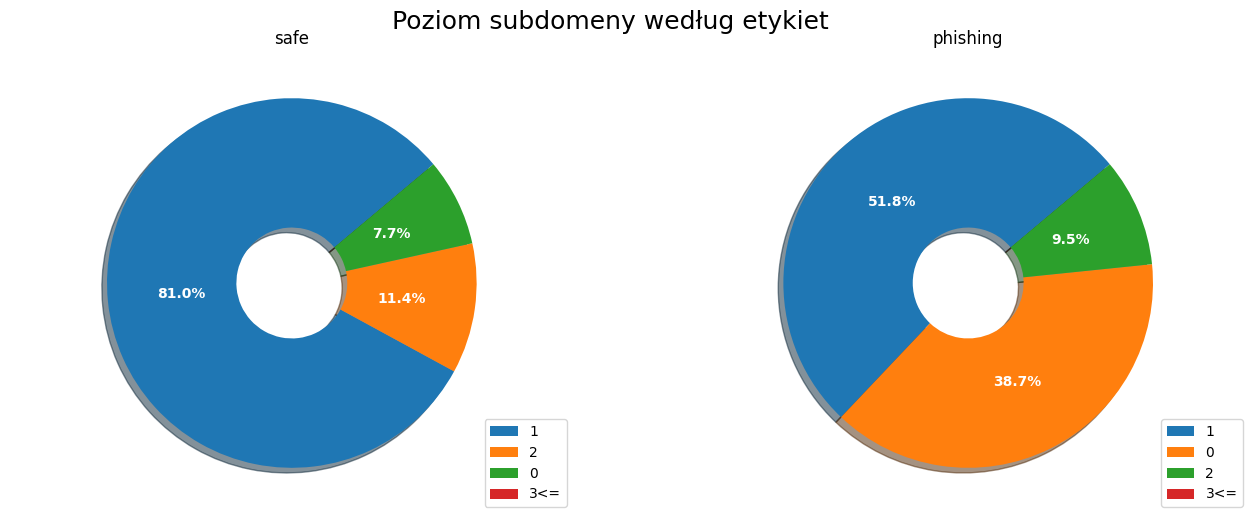

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# SAFE
legit_rows = mails[mails['label']=='safe']
dots_data = legit_rows['subdomain_level'].value_counts(normalize=True).to_dict()

labels = list(dots_data.keys())
values = list(dots_data.values())
autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

ax[0].axis('equal')
ax[0].set_title('safe')

wedges, texts, autotexts = ax[0].pie(x=values,
                                wedgeprops=dict(width=0.70),
                                autopct=autopct_format,
                                shadow=True,
                                startangle=40)

ax[0].legend(wedges, labels, loc='lower right')
plt.setp(autotexts, size=10, weight="bold", c='w')

# PHISHING
phishing_rows = mails[mails['label']=='phishing']
dots_data = phishing_rows['subdomain_level'].value_counts(normalize=True).to_dict()

labels = list(dots_data.keys())
values = list(dots_data.values())
autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

ax[1].axis('equal')
ax[1].set_title('phishing')

wedges, texts, autotexts = ax[1].pie(x=values,
                                wedgeprops=dict(width=0.70),
                                autopct=autopct_format,
                                shadow=True,
                                startangle=40)

ax[1].legend(wedges, labels, loc='lower right')
plt.setp(autotexts, size=10, weight="bold", c='w')

plt.suptitle('Poziom subdomeny według etykiet', fontsize=18, y=0.95)
plt.show()

In [16]:
print(mails.info(), end='\n\n')
print(mails['label'].value_counts(normalize=True), end='\n\n')
print(mails['protocol'].value_counts(normalize=True, dropna=False), end='\n\n')
print(mails['urls_count'].value_counts(normalize=True, dropna=False), end='\n\n')


<class 'pandas.core.frame.DataFrame'>
Index: 41716 entries, 0 to 99469
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Unnamed: 0       41716 non-null  int64   
 1   sender_mail      41716 non-null  object  
 2   subject          41716 non-null  object  
 3   body             41716 non-null  object  
 4   label            41716 non-null  category
 5   extracted_urls   41716 non-null  object  
 6   urls_count       41716 non-null  category
 7   in_body_url      41716 non-null  object  
 8   protocol         41716 non-null  category
 9   contains_ip      41716 non-null  bool    
 10  url_length       41716 non-null  int64   
 11  domain           41716 non-null  object  
 12  TLD              41716 non-null  object  
 13  TLD_alpha        41716 non-null  bool    
 14  subdomain_level  41148 non-null  category
dtypes: bool(2), category(4), int64(2), object(7)
memory usage: 3.4+ MB
None

label
phishing    0

In [17]:
mails.drop(mails.columns[0], axis=1, inplace=True)
print(mails.head(5))

                               sender_mail  \
0                          Young@iworld.de   
1                   ipline's1983@icable.ph   
2  Karmandeep-opengevl@universalnet.psi.br   
3                        ivqrnai@pobox.com   
4         externalsep1@loanofficertool.com   

                                                                                                                                                  subject  \
0                                                                                                                               Never agree to be a loser   
1                                                                                                                                  Befriend Jenna Jameson   
2                                                                                                                                    CNN.com Daily Top 10   
3  Re: svn commit: r619753 - in /spamassassin/trunk: lib/Mail/SpamAssassin/PerMsgStatus.pm lib/

In [18]:
def count_slashes(url):
    return url.count('/')


def map_slashes(num):
    if num <= 5:
        return str(num)
    else:
        return '6<='



mails['slash_count'] = mails['in_body_url'].apply(count_slashes)

mails['slash_count'] = mails['slash_count'].apply(map_slashes)
categories = pd.CategoricalDtype(['0', '1', '2', '3', '4', '5', '6<='], ordered=True)
mails['slash_count'] = mails['slash_count'].astype(categories)

In [19]:
def count_dots(url):
    return url.count('.')


def map_dots(num):
    if num <= 4:
        return str(num)
    else:
        return '5<='


mails['dots_count'] = mails['in_body_url'].apply(count_dots)

mails['dots_count'] = mails['dots_count'].apply(map_dots)
categories = pd.CategoricalDtype(['0', '1', '2', '3', '4', '5<='], ordered=True)
mails['dots_count'] = mails['dots_count'].astype(categories)

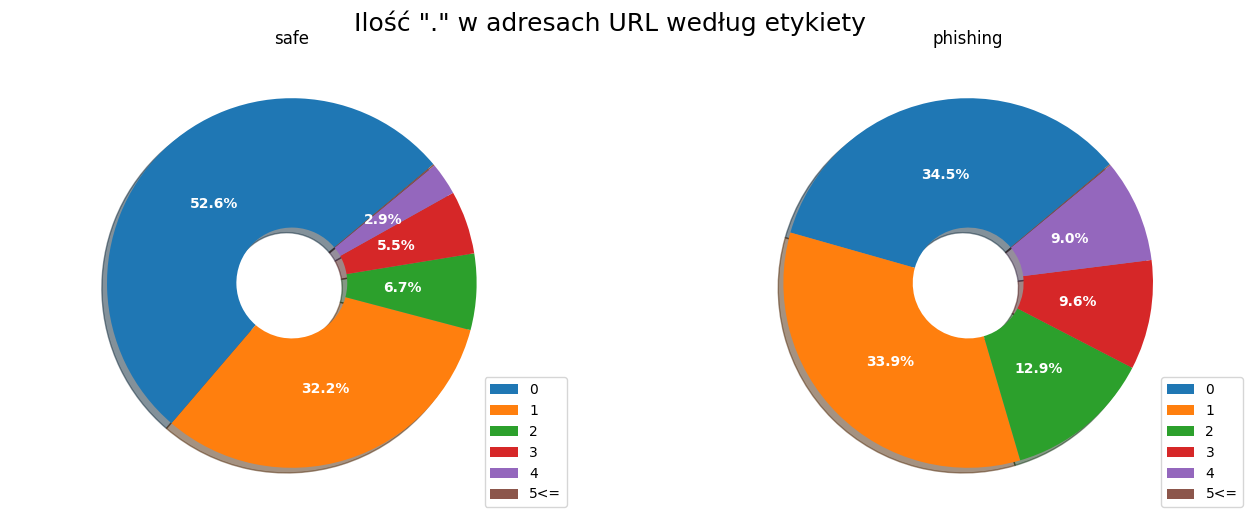

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# SAFE
legit_rows = mails[mails['label']=='safe']
dots_data = legit_rows['dots_count'].value_counts(normalize=True).to_dict()

labels = list(dots_data.keys())
values = list(dots_data.values())
autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

ax[0].axis('equal')
ax[0].set_title('safe')

wedges, texts, autotexts = ax[0].pie(x=values,
                                wedgeprops=dict(width=0.70),
                                autopct=autopct_format,
                                shadow=True,
                                startangle=40)

ax[0].legend(wedges, sorted(labels), loc='lower right')
plt.setp(autotexts, size=10, weight="bold", c='w')

# PHISHING
phishing_rows = mails[mails['label']=='phishing']
dots_data = phishing_rows['dots_count'].value_counts(normalize=True).to_dict()

labels = list(dots_data.keys())
values = list(dots_data.values())
autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

ax[1].axis('equal')
ax[1].set_title('phishing')

wedges, texts, autotexts = ax[1].pie(x=values,
                                wedgeprops=dict(width=0.70),
                                autopct=autopct_format,
                                shadow=True,
                                startangle=40)

ax[1].legend(wedges, sorted(labels), loc='lower right')
plt.setp(autotexts, size=10, weight="bold", c='w')

plt.suptitle('Ilość "." w adresach URL według etykiety', fontsize=18, y=0.95)
plt.show()

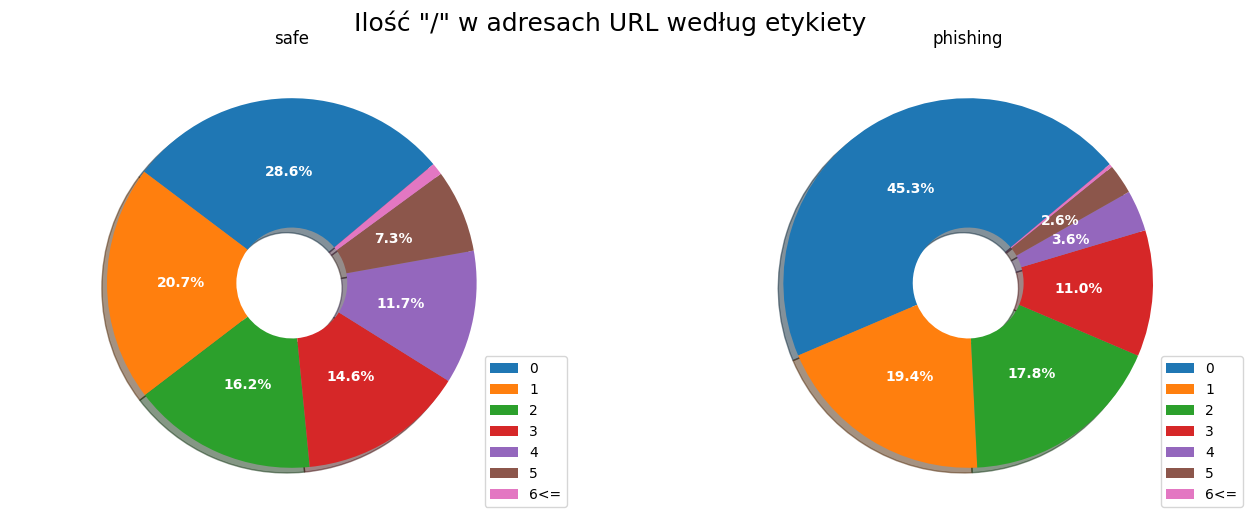

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# SAFE
legit_rows = mails[mails['label']=='safe']
dots_data = legit_rows['slash_count'].value_counts(normalize=True).to_dict()

labels = list(dots_data.keys())
values = list(dots_data.values())
autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

ax[0].axis('equal')
ax[0].set_title('safe')

wedges, texts, autotexts = ax[0].pie(x=values,
                                wedgeprops=dict(width=0.70),
                                autopct=autopct_format,
                                shadow=True,
                                startangle=40)

ax[0].legend(wedges, sorted(labels), loc='lower right')
plt.setp(autotexts, size=10, weight="bold", c='w')

# PHISHING
phishing_rows = mails[mails['label']=='phishing']
dots_data = phishing_rows['slash_count'].value_counts(normalize=True).to_dict()

labels = list(dots_data.keys())
values = list(dots_data.values())
autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

ax[1].axis('equal')
ax[1].set_title('phishing')

wedges, texts, autotexts = ax[1].pie(x=values,
                                wedgeprops=dict(width=0.70),
                                autopct=autopct_format,
                                shadow=True,
                                startangle=40)

ax[1].legend(wedges, sorted(labels), loc='lower right')
plt.setp(autotexts, size=10, weight="bold", c='w')

plt.suptitle('Ilość "/" w adresach URL według etykiety', fontsize=18, y=0.95)
plt.show()

In [22]:
print(mails.head(2))

              sender_mail                    subject  \
0         Young@iworld.de  Never agree to be a loser   
1  ipline's1983@icable.ph     Befriend Jenna Jameson   

                                                                                                                                                                                                      body  \
0  Buck up, your troubles caused by small dimension will soon be over!\nBecome a lover no woman will be able to resist!\nhttp://whitedone.com/\n\n\ncome. Even as Nazi tanks were rolling down the stre...   
1                                                                                                                   \nUpgrade your sex and pleasures with these techniques http://www.brightmade.com\n\n\n   

      label               extracted_urls urls_count  \
0  phishing      [http://whitedone.com/]          1   
1  phishing  [http://www.brightmade.com]          1   

                 in_body_url protocol  contain

In [23]:
print(mails.groupby('contains_ip').label.value_counts(normalize=True))

contains_ip  label   
False        phishing    0.613887
             safe        0.386113
True         phishing    0.901961
             safe        0.098039
Name: proportion, dtype: float64


In [28]:
print(mails.groupby('TLD_alpha').label.value_counts(normalize=True))

#print(mails.TLD.value_counts(normalize=True, ascending=True))

TLD_alpha  label   
False      safe        0.623989
           phishing    0.376011
True       phishing    0.619271
           safe        0.380729
Name: proportion, dtype: float64


In [25]:
print(mails[mails.TLD == ''])

Empty DataFrame
Columns: [sender_mail, subject, body, label, extracted_urls, urls_count, in_body_url, protocol, contains_ip, url_length, domain, TLD, TLD_alpha, subdomain_level, slash_count, dots_count]
Index: []
